In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
#bibliotecas de machine learning
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, ShuffleSplit

from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn import utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,KFold,GroupKFold
import lightgbm as lgb
import gc

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

In [9]:
# Se monta el drive
from google.colab import drive
drive.mount("/content/MyDrive/")

Mounted at /content/MyDrive/


In [10]:
#Importar datos de kaggle
!pip install kaggle # instalación paquete Kaggle
! mkdir ~/.kaggle # Importación base de datos (se crea la dirección)
! cp kaggle.json ~/.kaggle/ # Se accede al archivo .json
! chmod 600 ~/.kaggle/kaggle.json # Se accede al archivo .json
!kaggle datasets download -d mitishaagarwal/patient #Se descarga el .zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
 72% 6.00M/8.30M [00:00<00:00, 61.4MB/s]
100% 8.30M/8.30M [00:00<00:00, 79.0MB/s]


In [11]:
!unzip /content/patient.zip # Se descomprime el archivo .zip

Archive:  /content/patient.zip
  inflating: dataset.csv             


In [12]:
pre_datos=pd.read_csv('/content/dataset.csv')
# Se visualizaron los datos, su dimensión y tipo de varible
print(f'Dimensión de los datos: {pre_datos.shape}')
print(pre_datos.dtypes)
pre_datos

Dimensión de los datos: (91713, 85)
encounter_id                     int64
patient_id                       int64
hospital_id                      int64
age                            float64
bmi                            float64
                                ...   
solid_tumor_with_metastasis    float64
apache_3j_bodysystem            object
apache_2_bodysystem             object
Unnamed: 83                    float64
hospital_death                   int64
Length: 85, dtype: object


,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,...,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,Unnamed: 83,hospital_death
0,66154,25312,118,68.0,22.730000,0,Caucasian,M,180.3,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,NaN,0
1,114252,59342,81,77.0,27.420000,0,Caucasian,F,160.0,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,NaN,0
2,119783,50777,118,25.0,31.950000,0,Caucasian,F,172.7,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,NaN,0
3,79267,46918,118,81.0,22.640000,1,Caucasian,F,165.1,Operating Room / Recovery,...,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,NaN,0
4,92056,34377,33,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,91592,78108,30,75.0,23.060250,0,Caucasian,M,177.8,Floor,...,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular,NaN,0
91709,66119,13486,121,56.0,47.179671,0,Caucasian,F,183.0,Floor,...,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,NaN,0
91710,8981,58179,195,48.0,27.236914,0,Caucasian,M,170.2,Accident & Emergency,...,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,NaN,0
91711,33776,120598,66,NaN,23.297481,0,Caucasian,F,154.9,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,NaN,0


In [13]:
#Se quitan las columnas con mayor numeros de datos faltantes 
#(Las mayores a 10000)
large_missing = pre_datos.isnull().sum(axis=0).sort_values(ascending=False)[pre_datos.isnull().sum(axis=0).sort_values(ascending=False) > 10000]

#Se deja el dataset con los datos de màs relevancia para diagnostico
pre_datos.drop(large_missing.index.tolist() + ['encounter_id', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'patient_id', 'hospital_id'], 
              axis=1,
             inplace = True)
pre_datos

,age,bmi,elective_surgery,ethnicity,gender,height,icu_type,pre_icu_los_days,weight,apache_2_diagnosis,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,hospital_death
0,68.0,22.730000,0,Caucasian,M,180.3,CTICU,0.541667,73.9,113.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,0
1,77.0,27.420000,0,Caucasian,F,160.0,Med-Surg ICU,0.927778,70.2,108.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,0
2,25.0,31.950000,0,Caucasian,F,172.7,Med-Surg ICU,0.000694,95.3,122.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,0
3,81.0,22.640000,1,Caucasian,F,165.1,CTICU,0.000694,61.7,203.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,0
4,19.0,NaN,0,Caucasian,M,188.0,Med-Surg ICU,0.073611,NaN,119.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,75.0,23.060250,0,Caucasian,M,177.8,Cardiac ICU,0.298611,72.9,113.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular,0
91709,56.0,47.179671,0,Caucasian,F,183.0,Med-Surg ICU,0.120139,158.0,113.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,0
91710,48.0,27.236914,0,Caucasian,M,170.2,Med-Surg ICU,0.046528,78.9,123.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,0
91711,NaN,23.297481,0,Caucasian,F,154.9,Med-Surg ICU,0.081944,55.9,108.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,0


In [14]:
#Sustitucion de los datos faltantes por ceros eliminando las filas con dichos datos en bmi,peso,altura

pre_datos= pre_datos[pre_datos[['bmi', 'weight', 'height']].isna().sum(axis=1) == 0]
pre_datos

,age,bmi,elective_surgery,ethnicity,gender,height,icu_type,pre_icu_los_days,weight,apache_2_diagnosis,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,hospital_death
0,68.0,22.730000,0,Caucasian,M,180.3,CTICU,0.541667,73.9,113.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,0
1,77.0,27.420000,0,Caucasian,F,160.0,Med-Surg ICU,0.927778,70.2,108.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,0
2,25.0,31.950000,0,Caucasian,F,172.7,Med-Surg ICU,0.000694,95.3,122.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,0
3,81.0,22.640000,1,Caucasian,F,165.1,CTICU,0.000694,61.7,203.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,0
5,67.0,27.560000,0,Caucasian,M,190.5,Med-Surg ICU,0.000694,100.0,301.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,75.0,23.060250,0,Caucasian,M,177.8,Cardiac ICU,0.298611,72.9,113.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular,0
91709,56.0,47.179671,0,Caucasian,F,183.0,Med-Surg ICU,0.120139,158.0,113.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,0
91710,48.0,27.236914,0,Caucasian,M,170.2,Med-Surg ICU,0.046528,78.9,123.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,0
91711,NaN,23.297481,0,Caucasian,F,154.9,Med-Surg ICU,0.081944,55.9,108.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,0


In [15]:
#Clasificacion de los datos

numerical_cat = [
 'elective_surgery',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis']

categorical = ['ethnicity',
 'gender',
 'icu_type',
 'apache_3j_bodysystem',
 'apache_2_bodysystem']

In [16]:
#Columnas con solo dos elementos distintos (Es una variable binaria)

pre_datos.nunique()[pre_datos.nunique() == 2].index.tolist()

['elective_surgery',
 'gender',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis',
 'hospital_death']

In [17]:
pre_datos.select_dtypes(include='O').columns.values.tolist()

['ethnicity',
 'gender',
 'icu_type',
 'apache_3j_bodysystem',
 'apache_2_bodysystem']

In [18]:
#Mostrar solo los datos numericos

not_numeric = pre_datos[numerical_cat + categorical + ['hospital_death']].columns.tolist()
numeric_only = pre_datos.drop(not_numeric,axis=1).columns.tolist()
numeric_only

['age',
 'bmi',
 'height',
 'pre_icu_los_days',
 'weight',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_verbal_apache',
 'heart_rate_apache',
 'map_apache',
 'resprate_apache',
 'temp_apache',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'd1_resprate_max',
 'd1_resprate_min',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_sysbp_noninvasive_max',
 'd1_sysbp_noninvasive_min',
 'd1_temp_max',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_diasbp_min',
 'h1_diasbp_noninvasive_max',
 'h1_diasbp_noninvasive_min',
 'h1_heartrate_max',
 'h1_heartrate_min',
 'h1_mbp_max',
 'h1_mbp_min',
 'h1_mbp_noninvasive_max',
 'h1_mbp_noninvasive_min',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_spo2_max',
 'h1_spo2_min',
 'h1_sysbp_max',
 'h1_sysbp_min',
 'h1_sysbp_n

In [19]:
#Redondear valores numericos categoricos
for col in numerical_cat:
    pre_datos[col] = pre_datos[col].astype('Int64')

#Llenamos valores faltantes por sus respectivas modas
for col in numerical_cat:
    pre_datos[col] = pre_datos[col].fillna(pre_datos[col].mode()[0])

In [20]:
#Listamos la cantidad de valores faltantes en las columnas de tio de dato numerico

pre_datos[numeric_only].isna().sum(axis=0).sort_values(ascending=False)

d1_potassium_min                 9053
d1_potassium_max                 9053
h1_mbp_noninvasive_min           8455
h1_mbp_noninvasive_max           8455
apache_4a_icu_death_prob         7594
apache_4a_hospital_death_prob    7594
h1_diasbp_noninvasive_max        6982
h1_diasbp_noninvasive_min        6982
h1_sysbp_noninvasive_min         6972
h1_sysbp_noninvasive_max         6972
d1_glucose_min                   5458
d1_glucose_max                   5458
h1_mbp_min                       4287
h1_mbp_max                       4287
h1_resprate_min                  4062
h1_resprate_max                  4062
age                              4055
h1_spo2_min                      3925
h1_spo2_max                      3925
temp_apache                      3884
h1_diasbp_min                    3388
h1_diasbp_max                    3388
h1_sysbp_max                     3379
h1_sysbp_min                     3379
h1_heartrate_min                 2621
h1_heartrate_max                 2621
d1_temp_min 

In [21]:
#Columnas con menos de 11000 datos faltantes
split_one = pre_datos[numeric_only].isna().sum(axis=0).sort_values()[pre_datos[numeric_only].isna().sum(axis=0) < 11000].index.tolist()

#columnas con más de 11000 datos faltantes
split_two = pre_datos[numeric_only].isna().sum(axis=0).sort_values()[pre_datos[numeric_only].isna().sum(axis=0) > 11000].index.tolist()

In [22]:
process_data = pre_datos.dropna(axis=0)

In [23]:
process_data[categorical].nunique()

ethnicity                6
gender                   2
icu_type                 8
apache_3j_bodysystem    11
apache_2_bodysystem     10
dtype: int64

In [24]:
icu_data = pd.get_dummies(process_data,
    prefix='isin',
    prefix_sep='_',
    columns=categorical,
    drop_first=False)
icu_data.reset_index(drop = True, inplace = True)
icu_data

,age,bmi,elective_surgery,height,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,...,isin_Cardiovascular,isin_Gastrointestinal,isin_Haematologic,isin_Metabolic,isin_Neurologic,isin_Renal/Genitourinary,isin_Respiratory,isin_Trauma,isin_Undefined Diagnoses,isin_Undefined diagnoses
0,68.0,22.730000,0,180.3,0.541667,73.9,113.0,502.01,0,0,...,1,0,0,0,0,0,0,0,0,0
1,77.0,27.420000,0,160.0,0.927778,70.2,108.0,203.01,0,0,...,0,0,0,0,0,0,1,0,0,0
2,67.0,27.560000,0,190.5,0.000694,100.0,301.0,403.01,0,0,...,0,0,0,0,1,0,0,0,0,0
3,72.0,28.257052,1,154.9,0.004861,67.8,303.0,1304.08,1,0,...,0,0,0,0,0,0,1,0,0,0
4,46.0,25.845717,0,167.6,0.000000,72.6,108.0,203.01,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56981,47.0,51.439842,1,195.0,0.033333,186.0,304.0,1406.01,1,0,...,0,1,0,0,0,0,0,0,0,0
56982,54.0,19.770448,0,177.8,0.025694,62.5,109.0,108.01,0,0,...,1,0,0,0,0,0,0,0,0,0
56983,75.0,23.060250,0,177.8,0.298611,72.9,113.0,501.06,0,0,...,1,0,0,0,0,0,0,0,0,0
56984,56.0,47.179671,0,183.0,0.120139,158.0,113.0,501.05,0,0,...,1,0,0,0,0,0,0,0,0,0


In [25]:
icu_data.columns = [x.lower() for x in icu_data.columns.tolist()]
icu_data = icu_data.loc[:,~icu_data.columns.duplicated()]

In [26]:
t = icu_data['arf_apache'].dtype
for col in tqdm(icu_data.columns.tolist()):
    if icu_data[col].values.dtype == 'uint8' or t == icu_data[col].values.dtype:
        icu_data[col] = icu_data[col].astype(int)

100%|██████████| 104/104 [00:00<00:00, 1867.15it/s]


In [27]:
icu_data.dtypes

age                         float64
bmi                         float64
elective_surgery              int64
height                      float64
pre_icu_los_days            float64
                             ...   
isin_trauma                   int64
isin_haematologic             int64
isin_neurologic               int64
isin_renal/genitourinary      int64
isin_undefined diagnoses      int64
Length: 104, dtype: object

## Metodos supervisados

In [51]:
X = icu_data.drop(['hospital_death'], axis=1)
y = icu_data['hospital_death']

X_new = X[['apache_4a_hospital_death_prob','apache_4a_icu_death_prob','age','d1_spo2_min','d1_resprate_max','d1_heartrate_min']]

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.30, 
                                                    random_state=11, 
                                                    stratify = y)

In [52]:
print(X_train.shape)
print(y_train.shape)

(39890, 6)
(39890,)


In [53]:
#Función para reportar el error del modelo
def report_cv_score(z):
    
    #RMSE en prueba y entrenamiento
    lr_ts_score = z['test_score']*(-1)
    lr_tr_score = z['train_score']*(-1)
    lin_rmse_ts = np.sqrt(lr_ts_score)
    lin_rmse_tr = np.sqrt(lr_tr_score)
    print("RMSLE Test: ", "{:.5f}".format(np.mean(lin_rmse_ts)), "(±", "{:.8f}".format(np.std(lin_rmse_ts)),")")
    print("RMSLE Train: ", "{:.5f}".format(np.mean(lin_rmse_tr)), "(±", "{:.8f}".format(np.std(lin_rmse_tr)),")")

In [54]:
#Función para calcular el RMSLE de los modelos implementados
def RMSLE(y_actual, y_pred):
    
    return np.sqrt(mean_squared_error(y_actual, y_pred))

In [55]:
#librerias utilizadas 
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report,confusion_matrix

In [112]:
estimator1 = DecisionTreeRegressor(max_depth=2)
estimator2 = RandomForestRegressor(n_estimators = 50,max_depth = 5)

In [113]:
#Selección de modelos

zscores = []
estimators = [estimator1, estimator2]
for estimator in estimators:
    print("---------")
    z = cross_validate(estimator, X_train, y_train, return_train_score=True, return_estimator=False,
                       scoring="neg_mean_squared_error", cv=ShuffleSplit(n_splits=10, test_size=0.4))
    report_cv_score(z)
    zscores.append(np.mean(np.sqrt(z['test_score']*(-1))))
best = np.argmin(zscores)
print ("Seleccionado: ", best)
best_estimator = estimators[best]
print ("\n Mejor modelo: ")
print (best_estimator)

---------
RMSLE Test:  0.25133 (± 0.00181249 )
RMSLE Train:  0.24910 (± 0.00119303 )
---------
RMSLE Test:  0.24375 (± 0.00329053 )
RMSLE Train:  0.23718 (± 0.00228485 )
Seleccionado:  1

 Mejor modelo: 
RandomForestRegressor(max_depth=5, n_estimators=50)


## Hiperparametros

In [121]:
from sklearn.model_selection import GridSearchCV

In [122]:
parametros = {'max_depth': [2,5,8,12,15]}


decission_tree = GridSearchCV(estimator = estimator1,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=0.4), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)

decission_tree.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4, train_size=None),
             estimator=DecisionTreeRegressor(max_depth=2), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 8, 12, 15]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [123]:
print("Mejor estimador Decision Tree: ",decission_tree.best_estimator_)
print("Mejores parámetros para el estimador Decision Tree: ", decission_tree.best_params_)

Mejor estimador Decision Tree:  DecisionTreeRegressor(max_depth=5)
Mejores parámetros para el estimador Decision Tree:  {'max_depth': 5}


In [124]:
Des_tree = DecisionTreeRegressor(max_depth=5)
Des_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5)

In [125]:
#Desempeño del modelo Desicion Tree seleccionado

print('RMSLE del Decision Tree en entrenamiento: ',"{:.5f}".format(RMSLE((y_train) , (Des_tree.predict(X_train)))))
print('RMSLE del Decision Tree seleccionado: ',"{:.5f}".format(RMSLE(y_test , Des_tree.predict(X_test))))

RMSLE del Decision Tree en entrenamiento:  0.24157
RMSLE del Decision Tree seleccionado:  0.24821


Random Forest

In [191]:

parametros = { 'n_estimators': [5,10,15,50,60],
              'max_depth':[5,7,9]}

forest_reg = GridSearchCV(estimator = estimator2,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=0.4), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)
forest_reg.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4, train_size=None),
             estimator=RandomForestRegressor(max_depth=5, n_estimators=50),
             n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9],
                         'n_estimators': [5, 10, 15, 50, 60]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [192]:
print("Mejor estimador Random Forest: ",forest_reg.best_estimator_)
print("Mejores parámetros para el estimador Random Forest: ", forest_reg.best_params_)

Mejor estimador Random Forest:  RandomForestRegressor(max_depth=7, n_estimators=60)
Mejores parámetros para el estimador Random Forest:  {'max_depth': 7, 'n_estimators': 60}


In [193]:
Rdm_forest = RandomForestRegressor(n_estimators = 60,max_depth = 7)
Rdm_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, n_estimators=60)

In [195]:
print('RMSLE del Random Forest en entrenamiento: ',"{:.5f}".format(RMSLE((y_train) , (Rdm_forest.predict(X_train)))))
print('RMSLE del Random Forest seleccionado: ',"{:.5f}".format(RMSLE(y_test , Rdm_forest.predict(X_test))))

RMSLE del Random Forest en entrenamiento:  0.23345
RMSLE del Random Forest seleccionado:  0.24553


## Metodos no supervisados

In [132]:
pre_datos.head()

,age,bmi,elective_surgery,ethnicity,gender,height,icu_type,pre_icu_los_days,weight,apache_2_diagnosis,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,hospital_death
0,68.0,22.73,0,Caucasian,M,180.3,CTICU,0.541667,73.9,113.0,...,0,1,0,0,0,0,0,Sepsis,Cardiovascular,0
1,77.0,27.42,0,Caucasian,F,160.0,Med-Surg ICU,0.927778,70.2,108.0,...,0,1,0,0,0,0,0,Respiratory,Respiratory,0
2,25.0,31.95,0,Caucasian,F,172.7,Med-Surg ICU,0.000694,95.3,122.0,...,0,0,0,0,0,0,0,Metabolic,Metabolic,0
3,81.0,22.64,1,Caucasian,F,165.1,CTICU,0.000694,61.7,203.0,...,0,0,0,0,0,0,0,Cardiovascular,Cardiovascular,0
5,67.0,27.56,0,Caucasian,M,190.5,Med-Surg ICU,0.000694,100.0,301.0,...,0,1,0,0,0,0,0,Neurological,Neurologic,0


In [165]:
from sklearn.decomposition import PCA
components = [1,3,5,7,9]
test_size = 0.3
val_size  = test_size/(1-test_size)
perf = [] #desempeños de los modelos
Rdm_forest = RandomForestRegressor(n_estimators = 5,max_depth = 7)
for i in components:
    pca = PCA(n_components = i)
    
    #Partición de datos
    #Xtv, ytv son los datos que se usan para entrenar el modelo
    #Xts, yts son los datos que se usan para probar el modelo (solo se usan para el testeo final de los modelos que se seleccionen)
    Xtv, Xts, ytv, yts = train_test_split(X_train, y_train, test_size=test_size)
    print (Xtv.shape, Xts.shape)
    
    Rdm_forest.fit(Xtv, ytv)
    perf.append(RMSLE(yts , Rdm_forest.predict(Xts)))
    print('RMSLE del modelo con ', i ,'elementos: ',"{:.5f}".format(RMSLE(yts , Rdm_forest.predict(Xts))))
    print('------------')

print('Mejor RMSLE: ',"{:.5f}".format(np.min(perf)),'  ; obtenido con ',components[np.argmin(perf)],' componentes para PCA')
    

(27923, 6) (11967, 6)
RMSLE del modelo con  1 elementos:  0.25026
------------
(27923, 6) (11967, 6)
RMSLE del modelo con  3 elementos:  0.24612
------------
(27923, 6) (11967, 6)
RMSLE del modelo con  5 elementos:  0.24523
------------
(27923, 6) (11967, 6)
RMSLE del modelo con  7 elementos:  0.24475
------------
(27923, 6) (11967, 6)
RMSLE del modelo con  9 elementos:  0.24566
------------
Mejor RMSLE:  0.24475   ; obtenido con  7  componentes para PCA


In [166]:
#MEJOR PCA
pca = PCA(n_components = 5)
Xtv, Xts, ytv, yts = train_test_split(X_train, y_train, test_size=test_size)
print (Xtv.shape, Xts.shape)

(27923, 6) (11967, 6)


In [167]:
parametros = { 'n_estimators': [5,10,15],
              'max_depth':[5,7,9]}

forest_reg = GridSearchCV(estimator = estimator2,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)
forest_reg.fit(Xtv, ytv)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=RandomForestRegressor(max_depth=5, n_estimators=50),
             n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9], 'n_estimators': [5, 10, 15]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [168]:
print("Mejor estimador Random Forest: ",forest_reg.best_estimator_)
print("Mejores parámetros para el estimador Random Forest: ", forest_reg.best_params_)

Mejor estimador Random Forest:  RandomForestRegressor(max_depth=5, n_estimators=10)
Mejores parámetros para el estimador Random Forest:  {'max_depth': 5, 'n_estimators': 10}


In [169]:
#Mejor random forest para el PCA obtenido
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_train, y_train, test_size=test_size)
print (Xtv.shape, Xts.shape)
Rdm_forest = RandomForestRegressor(n_estimators = 10,max_depth = 5)
Rdm_forest.fit(Xtv, ytv)

(27923, 6) (11967, 6)


RandomForestRegressor(max_depth=5, n_estimators=10)

In [170]:
#Desempeño del modelo Random Forest seleccionado

print('RMSLE del Random Forest en entrenamiento: ',"{:.5f}".format(RMSLE((ytv) , (Rdm_forest.predict(Xtv)))))
print('RMSLE del Random Forest seleccionado: ',"{:.5f}".format(RMSLE(yts , Rdm_forest.predict(Xts))))

RMSLE del Random Forest en entrenamiento:  0.24051
RMSLE del Random Forest seleccionado:  0.23891


NMF

In [171]:
from sklearn.decomposition import NMF
components = [1,3,5,7,9]
test_size = 0.3
val_size  = test_size/(1-test_size)
perf = [] #desempeños de los modelos
Des_tree = DecisionTreeRegressor(max_depth=5)
for i in components:
    nmf = NMF(n_components = i)
    
    #Partición de datos
    #Xtv, ytv son los datos que se usan para entrenar el modelo
    #Xts, yts son los datos que se usan para probar el modelo (solo se usan para el testeo final de los modelos que se seleccionen)
    Xtv, Xts, ytv, yts = train_test_split(X_train, y_train, test_size=test_size)
    print (Xtv.shape, Xts.shape)
    
    Des_tree.fit(Xtv, ytv)
    perf.append(RMSLE(yts , Des_tree.predict(Xts)))
    print('RMSLE del modelo con ', i ,'elementos: ',"{:.5f}".format(RMSLE(yts , Des_tree.predict(Xts))))
    print('------------')

print('Mejor RMSLE: ',"{:.5f}".format(np.min(perf)),'  ; obtenido con ',components[np.argmin(perf)],' componentes para PCA')

(27923, 6) (11967, 6)
RMSLE del modelo con  1 elementos:  0.24197
------------
(27923, 6) (11967, 6)
RMSLE del modelo con  3 elementos:  0.24261
------------
(27923, 6) (11967, 6)
RMSLE del modelo con  5 elementos:  0.24327
------------
(27923, 6) (11967, 6)
RMSLE del modelo con  7 elementos:  0.25233
------------
(27923, 6) (11967, 6)
RMSLE del modelo con  9 elementos:  0.24430
------------
Mejor RMSLE:  0.24197   ; obtenido con  1  componentes para PCA


In [172]:
#MEJOR NMF
nmf = NMF(n_components = 3)
Xtv, Xts, ytv, yts = train_test_split(X_train, y_train, test_size=test_size)
print (Xtv.shape, Xts.shape)

(27923, 6) (11967, 6)


In [173]:
parametros = {'max_depth': [2,5,8,12,15]}


decission_tree = GridSearchCV(estimator = estimator1,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)

decission_tree.fit(Xtv, ytv)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=DecisionTreeRegressor(max_depth=2), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 8, 12, 15]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [174]:
print("Mejor estimador Decision Tree: ",decission_tree.best_estimator_)
print("Mejores parámetros para el estimador Decision Tree: ", decission_tree.best_params_)

Mejor estimador Decision Tree:  DecisionTreeRegressor(max_depth=5)
Mejores parámetros para el estimador Decision Tree:  {'max_depth': 5}


In [175]:
#Mejor Decision Tree para el NMF obtenido
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_train, y_train, test_size=test_size)
print (Xtv.shape, Xts.shape)
Des_tree = DecisionTreeRegressor(max_depth=15)
Des_tree.fit(Xtv, ytv)

(27923, 6) (11967, 6)


DecisionTreeRegressor(max_depth=15)

In [176]:
print('RMSLE del Decision Tree en entrenamiento: ',"{:.5f}".format(RMSLE((ytv) , (Des_tree.predict(Xtv)))))
print('RMSLE del Decision Tree seleccionado: ',"{:.5f}".format(RMSLE(yts , Des_tree.predict(Xts))))
print('RMSLE del Decision Tree en entrenamiento: ',"{:.5f}".format(RMSLE((ytv) , (Des_tree.predict(Xtv)))))
print('RMSLE del Decision Tree seleccionado: ',"{:.5f}".format(RMSLE(yts , Des_tree.predict(Xts))))

RMSLE del Decision Tree en entrenamiento:  0.16078
RMSLE del Decision Tree seleccionado:  0.30731
RMSLE del Decision Tree en entrenamiento:  0.16078
RMSLE del Decision Tree seleccionado:  0.30731


## Curvas de aprendizaje

## Metodos supervisados

In [177]:
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (X.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

#Xtv, ytv son los datos que se usan para entrenar el modelo
#Xts, yts son los datos que se usan para probar el modelo (solo se usan para el testeo final de los modelos que se seleccionen)
Xtv, Xts, ytv, yts = train_test_split(X_train, y_train, test_size=test_size)
print (Xtv.shape, Xts.shape)

(56986, 103) (56986,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(27923, 6) (11967, 6)


**Arboles de decision**

In [196]:
Des_tree1 = DecisionTreeRegressor(max_depth=5)
train_sizes, train_scores, valid_scores = learning_curve(Des_tree1, Xtv, ytv, train_sizes= [0.3, 0.5,0.7,0.9], 
                 scoring ='neg_root_mean_squared_error', cv = ShuffleSplit(n_splits=10, test_size=val_size))

In [197]:
train_mean

array([0.22808721, 0.23381979, 0.23711587, 0.23725133])

In [198]:
valid_mean

array([0.2533285 , 0.25018249, 0.24774644, 0.24683168])

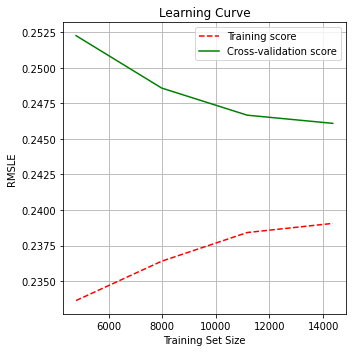

In [199]:
train_scores = np.abs(train_scores)
valid_scores = np.abs(valid_scores)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

plt.subplots(1, figsize=(5,5))
plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
plt.plot(train_sizes, valid_mean, color="g", label="Cross-validation score")



plt.grid()
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSLE"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [200]:
def lc_plot(estimator,X,y):
    train_sizes, train_scores, valid_scores = learning_curve(estimator, X, y, train_sizes= [0.3, 0.5,0.7,0.9], 
                 scoring ='neg_root_mean_squared_error', cv = ShuffleSplit(n_splits=10, test_size=val_size))
    
    train_scores = np.abs(train_scores)
    valid_scores = np.abs(valid_scores)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    plt.subplots(1, figsize=(5,5))
    plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
    plt.plot(train_sizes, valid_mean, color="g", label="Cross-validation score")



    plt.grid()
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("RMSLE"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    return plt

Random forest

In [203]:
Rdm_forest = RandomForestRegressor(n_estimators = 60,max_depth = 7)

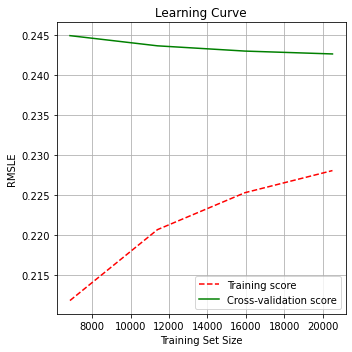

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [204]:
lc_plot(Rdm_forest,X_train, y_train)

In [205]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 5)
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_train, y_train, test_size=test_size)
Rdm_forest = RandomForestRegressor(n_estimators = 15,max_depth = 7)

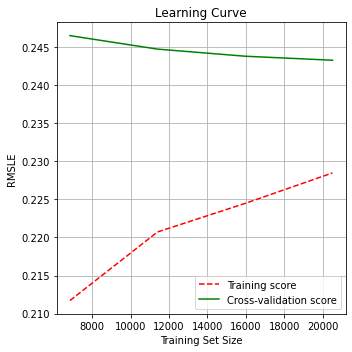

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [206]:
lc_plot(Rdm_forest,X_train, y_train)

In [207]:
from sklearn.decomposition import NMF
nmf = NMF(n_components = 3)
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_train, y_train, test_size=test_size)
Des_tree = DecisionTreeRegressor(max_depth=5)

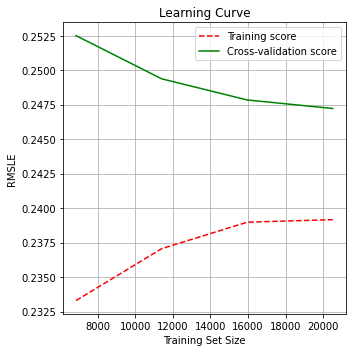

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [208]:
lc_plot(Des_tree,X_train, y_train)